In [ ]:
import xgboost as xgb
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
SEED = 42

In [3]:
# should still check when to stratify
def preprocess_dataset(dataset, categorical_encoding='label', categorical_type='category'):
    dataset = copy.deepcopy(dataset) # to preserve mutable object
    # if there is no default test data
    if dataset['test_data'] is None:
        X_train, X_test, y_train, y_test = train_test_split(dataset['data'], dataset['target'], test_size=0.25,
                                                            random_state=SEED)
        dataset['data'] = X_train
        dataset['target'] = y_train
        dataset['test_data'] = X_test
        dataset['test_target'] = y_test

    # label encoding for classification task, float for regression
    if dataset['task'] == 'classification':
        label_encoder = LabelEncoder()
        dataset['label_encoder'] = label_encoder
        dataset['target_processed'] = label_encoder.fit_transform(dataset['target'])
        dataset['test_target_processed'] = label_encoder.transform(dataset['test_target'])
    else:
        dataset['label_encoder'] = None
        dataset['target_processed'] = dataset['target'].astype('float')
        dataset['test_target_processed'] = dataset['test_target'].astype('float')
    # encodes categorical data
    if categorical_encoding == 'label':
    # order of columns is preserved
        encoder = OrdinalEncoder(encoded_missing_value=-1)
        dataset['encoder'] = encoder
        dataset['data'].iloc[:,dataset['cat_features']] = encoder.fit_transform(
            dataset['data'].iloc[:,dataset['cat_features']])
        dataset['test_data'].iloc[:,dataset['cat_features']] = encoder.transform(
            dataset['test_data'].iloc[:,dataset['cat_features']])
    if categorical_encoding == 'one_hot':
    # in the case of the one hot encoding we will first have the continuous columns and after the categorical
    # (one hot encoded)
        encoder = OneHotEncoder(drop='if_binary',sparse=False) # Nan is treated as another category (extra column)
        dataset['encoder'] = encoder
        dataset['data'] = (dataset['data'].iloc[:,dataset['cont_features']]
                           .join(pd.DataFrame(encoder.fit_transform(dataset['data'].iloc[:,dataset['cat_features']]))))
        dataset['test_data'] = (dataset['test_data'].iloc[:,dataset['cont_features']]
                                .join(pd.DataFrame(encoder.transform(dataset['test_data'].
                                                                     iloc[:,dataset['cat_features']]))))
        dataset['cont_features'] = [i for i in range(len(dataset['cont_features']))]
        dataset['cat_features'] = [i for i in range(len(dataset['cont_features']),dataset['data'].shape[1])]

    # continuous features as float and categorical features as category
    # obs: for some reason it does not work with iloc[:,dataset['cat_features']], we use 
    # .columns[dataset['cat_features']] instead...
    dataset['data'][dataset['data'].columns[dataset['cat_features']]] = (
        dataset['data'][dataset['data'].columns[dataset['cat_features']]].astype(categorical_type))
    dataset['test_data'][dataset['data'].columns[dataset['cat_features']]] = (
        dataset['test_data'][dataset['data'].columns[dataset['cat_features']]].astype(categorical_type))
    dataset['data'][dataset['data'].columns[dataset['cont_features']]] = (
        dataset['data'][dataset['data'].columns[dataset['cont_features']]].astype('float'))
    dataset['test_data'][dataset['data'].columns[dataset['cont_features']]] = (
        dataset['test_data'][dataset['data'].columns[dataset['cont_features']]].astype('float'))
    return dataset

In [4]:
def run_xgb(dataset):
    verbose = 0
    if dataset['task'] == 'classification':
        n_classes = len(np.unique(dataset['target_processed']))
        if n_classes == 2:
            objective = 'binary:logistic'
            eval_metrics = ['logloss','auc']
        elif n_classes > 2:
            objective = 'multi:softprob'
            eval_metrics = ['mlogloss','auc']
        else:
            error = True
        model = xgb.XGBClassifier(objective=objective, eval_metric=eval_metrics, use_label_encoder=False,
                                  random_state=SEED)
    if dataset['task'] == 'regression':
        objective = 'reg:squarederror'
        eval_metrics = ['rmse']
        model = xgb.XGBRegressor(objective=objective, eval_metric=eval_metrics, random_state=SEED)
    X_train = dataset['data']
    y_train = dataset['target_processed']
    X_test = dataset['test_data']
    y_test = dataset['test_target_processed']
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=verbose)
    return model

In [5]:
def plot_learning_curve(model, name):
    result = model.evals_result()
    for metric in result['validation_0']:
        fig, ax = plt.subplots()
        ax.plot(result['validation_0'][metric], label='train')
        ax.plot(result['validation_1'][metric], label='validation')
        ax.legend()
        ax.set_xlabel('iteration')
        ax.set_ylabel(metric)
        ax.set_title(name)

In [6]:
# iris
iris = datasets.load_iris(as_frame=True)
iris.update({
    'name':'iris',
    'task':'classification',
    'cat_features':[],
    'cont_features':[0, 1, 2, 3],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# diabetes
diabetes = datasets.load_diabetes(as_frame=True)
diabetes.update({
    'name':'diabetes',
    'task':'regression',
    'cat_features':[],
    'cont_features':[i for i in range(10)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# wine
wine = datasets.load_wine(as_frame=True)
wine.update({
    'name':'wine',
    'task':'classification',
    'cat_features':[],
    'cont_features':[i for i in range(13)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# breast cancer
breast_cancer = datasets.load_breast_cancer(as_frame=True)
breast_cancer.update({
    'name':'breast_cancer',
    'task':'classification',
    'cat_features':[],
    'cont_features':[i for i in range(30)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# covtype
covtype = datasets.fetch_covtype(as_frame=True)
covtype.update({
    'name':'covtype',
    'task':'classification',
    'cat_features':[i for i in range(10,54)],
    'cont_features':[i for i in range(10)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# kddcup99_sa
# obs we have a problem in the data, the classes b'nmap.', b'pod.', b'portsweep.' only have one single example,
# so we filter it - > Actually we will not use it for now, because each time we fetch the dataset we select a random
# sample from the total dataset and different cases of infrequent classes must be handle....to do one day
# kddcup99_sa = datasets.fetch_kddcup99(subset='SA', as_frame=True, random_state=SEED)
# kddcup99_sa.update({
#     'name':'fetch_kddcup99_sa',
#     'task':'classification',
#     'cat_features':[1, 2, 3, 6, 11, 20, 21],
#     'cont_features':[0, 4, 5] + [i for i in range(7, 11)] + [i for i in range(12, 20)] + [i for i in range(22, 40)],
#     'data': kddcup99_sa['data'].loc[~kddcup99_sa['target'].isin([b'nmap.', b'pod.', b'portsweep.'])],
#     'target': kddcup99_sa['target'].loc[~kddcup99_sa['target'].isin([b'nmap.', b'pod.', b'portsweep.'])],
#     'test_data':None,
#     'test_target':None
# })
# kddcup99_sf
kddcup99_sf = datasets.fetch_kddcup99(subset='SF', as_frame=True)
kddcup99_sf.update({
    'name':'fetch_kddcup99_sf',
    'task':'classification',
    'cat_features':[1],
    'cont_features':[0, 2, 3],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})
# california_housing 
california_housing = datasets.fetch_california_housing(as_frame=True)
california_housing.update({
    'name':'california_housing',
    'task':'regression',
    'cat_features':[],
    'cont_features':[i for i in range(7)],
#     'data': already specified when loading the dataset from scikit-learn
#     'target': already specified when loading the dataset from scikit-learn
    'test_data':None,
    'test_target':None
})

# download dataset from uci
url_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
url_test = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
nan_token = ' ?'
adult = {
    'name':'adult',
    'task':'classification',
    'cat_features':[1, 3, 5, 6, 7, 8, 9, 13],
    'cont_features':[0, 2, 4, 10, 11, 12],
    'data':pd.read_csv(url_data, header=None, na_values=nan_token).iloc[:,0:-1],
    'target':pd.read_csv(url_data, header=None, na_values=nan_token).iloc[:,-1],
    'test_data':pd.read_csv(url_test, header=None, skiprows=1, na_values=nan_token).iloc[:,0:-1],
    'test_target':pd.read_csv(url_test, header=None, skiprows=1, na_values=nan_token).iloc[:,-1].str[:-1]
}

all_datasets = [iris, diabetes, wine, breast_cancer, covtype, kddcup99_sf, california_housing, adult]

In [7]:
models = []
for dataset in all_datasets:
    print(dataset['name'])
    dataset_preprocessed = preprocess_dataset(dataset, 'label', 'float')
    models.append(run_xgb(dataset_preprocessed))

iris
diabetes


/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


wine
breast_cancer
covtype


/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


fetch_kddcup99_sf
[13:41:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.


/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:41:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only posi

[13:41:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:41:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only posi

/home/users/belucci/miniconda3/envs/xgboost/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [13]:
dataset = all_datasets[5]

In [14]:
dataset_preprocessed = preprocess_dataset(dataset, 'label', 'float')

In [26]:
dataset_preprocessed['task']

'classification'

In [29]:
dataset = dataset_preprocessed
verbose = 0
if dataset['task'] == 'classification':
    n_classes = len(np.unique(dataset['target_processed']))
    if n_classes == 2:
        objective = 'binary:logistic'
        eval_metrics = ['logloss','auc']
    elif n_classes > 2:
        objective = 'multi:softprob'
        eval_metrics = ['mlogloss','auc']
    else:
        error = True
    model = xgb.XGBClassifier(objective=objective, eval_metric=eval_metrics, use_label_encoder=False,
                              random_state=SEED)
if dataset['task'] == 'regression':
    objective = 'reg:squarederror'
    eval_metrics = ['rmse']
    model = xgb.XGBRegressor(objective=objective, eval_metric=eval_metrics, random_state=SEED)
X_train = dataset['data']
y_train = dataset['target_processed']
X_test = dataset['test_data']
y_test = dataset['test_target_processed']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)
eval_set = [(X_train, y_train), (X_val, y_val)]

In [30]:
model.fit(X_train, y_train, eval_set=eval_set, verbose=verbose)

[13:57:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only posi

[13:57:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only positive or negative samples.
[13:57:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/metric/auc.cc:307: Dataset contains only posi

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric=['mlogloss', 'auc'], gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=20, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [22]:
pd.value_counts(y_train)

8     39319
0      1256
14      571
1        16
6         7
11        5
2         5
7         4
5         3
10        2
9         2
12        1
15        1
3         1
13        1
4         1
dtype: int64

In [31]:
pd.value_counts(y_val)

8     13120
0       399
14      200
1         7
12        3
10        1
6         1
2         1
dtype: int64

In [32]:
pd.value_counts(y_test)

8     17500
0       548
14      249
1         7
12        2
15        1
9         1
10        1
5         1
dtype: int64

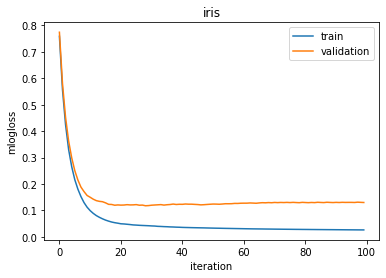

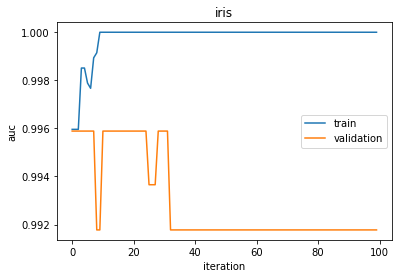

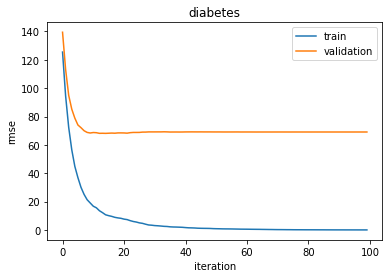

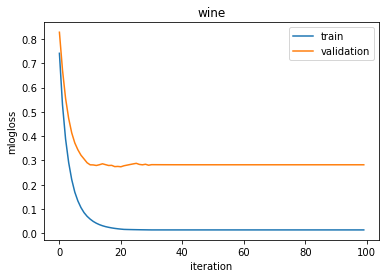

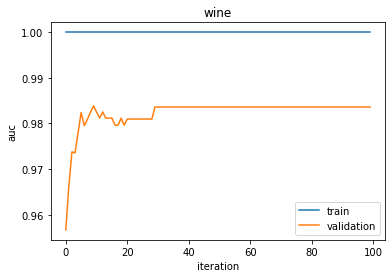

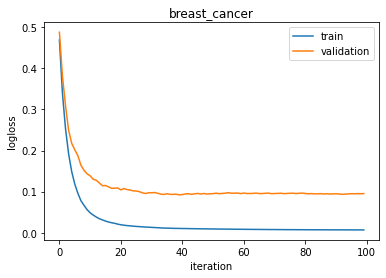

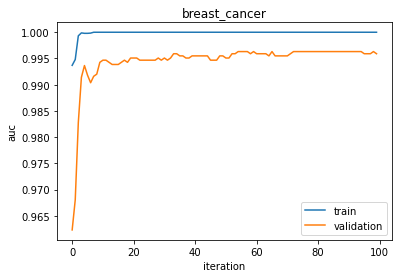

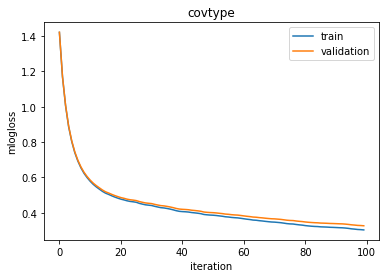

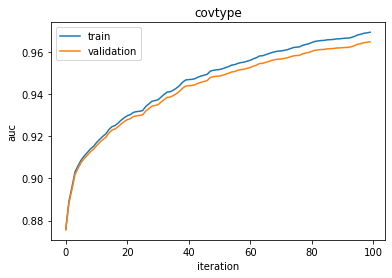

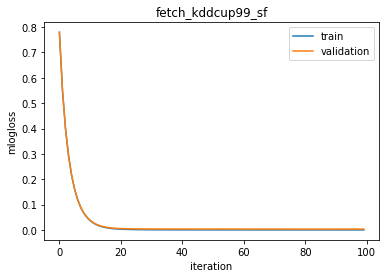

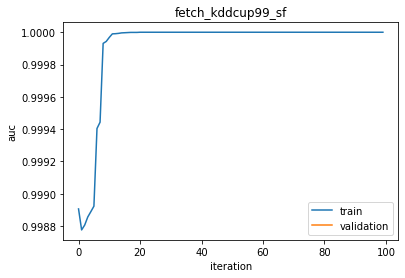

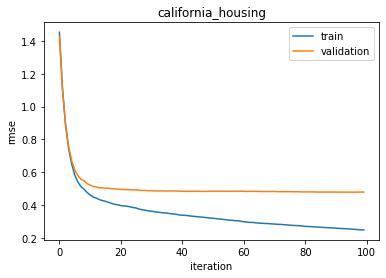

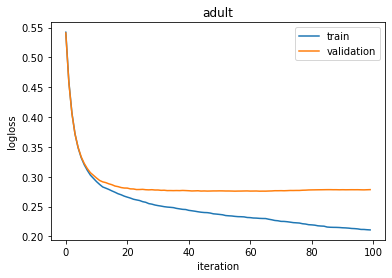

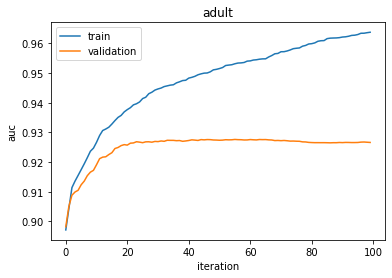

In [8]:
for model, dataset in zip(models,all_datasets):
    plot_learning_curve(model, dataset['name'])